# Measuring Similarities of Languages

I always felt that the situation in with Spanish and Catalan in Catlunya is very similat to the situation in with High German and Swiss German in Switzerland, until I got into an argument with a linguist friend, who claimed that Swiss German is only a dialect. There seem to be two criteria distinguishing a dialect from a real language: Not everything can be expressed in the dialect or everything is understood by everyone speaking the language. Having gone through lectures on Effective Quantum Field Theories in Bernese Swiss German and having experienced problems with my High German in Germany, I guess Swiss German is a language too.

Anyway, to resolve the dispute I turned to data and played around with measuring differences using compression algorithms on biblical texts. Enjoy.

In [1]:
import sys
import zlib
import itertools

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from data.luke23 import texts

In [2]:
def zipstance(text0, text1):
    """Similarity of texts based on compressability"""

    def zipsize(text):
        return sys.getsizeof(zlib.compress(bytes(text, 'UTF-8'), 9))

    return 2 * zipsize(text0 + text1) / (zipsize(text0) + zipsize(text1)) - 1


def dist_matrix(texts, metric):
    dm = pd.DataFrame()
    for combo in itertools.combinations_with_replacement(texts.keys(), 2):
        dist = metric(texts[combo[0]], texts[combo[1]])
        dm.loc[combo[0], combo[1]] = dist
        dm.loc[combo[1], combo[0]] = dist
    return dm

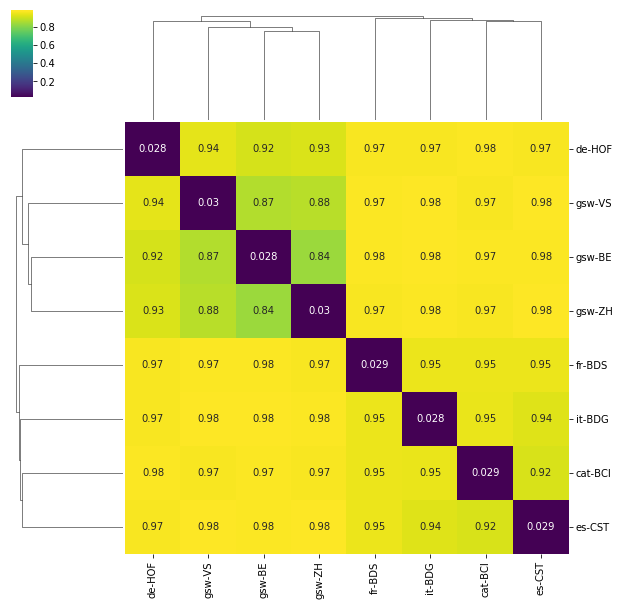

In [3]:
dm = dist_matrix(texts, zipstance)
hm = sns.clustermap(
    dm, standard_scale=None, method='single', cmap='viridis', annot=True)
plt.setp(hm.ax_heatmap.xaxis.get_majorticklabels(), rotation='vertical')
plt.setp(hm.ax_heatmap.yaxis.get_majorticklabels(), rotation='horizontal')
plt.show()

To get a feeling for the quality of `zipstance` I use property-based testing. However, more recent versions of `hypothesis` are much better at finding failing edge cases 😃

In [4]:
import unittest
import random
import string

from hypothesis import given, settings, HealthCheck
from hypothesis.strategies import text, floats

In [5]:
class TestZipstance(unittest.TestCase):

    @given(text(), text())
    def test_positivity(self, a, b):
        self.assertTrue(zipstance(a, b) >= 0)

    @given(text(min_size=10), text(min_size=10))
    def test_coincidence(self, a, b):
        aa = zipstance(a, a)
        bb = zipstance(b, b)
        ab = zipstance(a, b)
        self.assertTrue(aa <= ab)
        self.assertTrue(bb <= ab)

    @settings(suppress_health_check=HealthCheck.all())
    @given(text(min_size=1000), text(min_size=1000))
    def test_symmetry(self, a, b):
        eps = 0.02
        ab = zipstance(a, b)
        ba = zipstance(b, a)
        self.assertTrue(ab <= ba + eps)
        self.assertTrue(ab >= ba - eps)

    @given(text(min_size=10), text(min_size=10), text(min_size=10))
    def test_triangle_inequality(self, a, b, c):
        self.assertTrue(zipstance(a, c) <= zipstance(a, b) + zipstance(b, c))

    @given(floats(0, 1))
    def test_precision(self, ratio):
        """zipstance(a, x*a + (1 - x)*b) ~ 1 - x, if zipstance(a, b) ~ 1"""
        eps = 0.02
        n = 10000
        a = ''.join([
            random.choice(string.ascii_letters + '. ') for _ in range(n)])
        b = ''.join([
            random.choice(string.ascii_letters + '. ') for _ in range(n)])
        dist = zipstance(a, a[0:int(ratio * n)] + b[int(ratio * n):])
        self.assertTrue(dist >= 1 - ratio - eps)
        self.assertTrue(dist <= 1 - ratio + eps)


unittest.main(argv=['first-arg-is-ignored'], exit=False)

F.

Falsifying example: test_coincidence(self=<__main__.TestZipstance testMethod=test_coincidence>, a='0000000000', b='000000000/')

You can reproduce this example by temporarily adding @reproduce_failure('3.66.0', b'AXicY2RgYMSN8MkxAiEAAtQAFg==') as a decorator on your test case


./home/germann/Software/anaconda/lib/python3.6/site-packages/hypothesis/core.py:1084: HypothesisDeprecationWarning: Your tests are hitting the settings timeout (60.00s). This functionality will go away in a future release and you should not rely on it. Instead, try setting max_examples to be some value lower than 0 (the number of examples your test successfully ran here). Or, if you would prefer your tests to run to completion, regardless of how long they take, you can set the timeout value to hypothesis.unlimited.
  state.run()
E

You can add @seed(23533036049746109963779717980988758793) to this test to reproduce this failure.


F

Falsifying example: test_triangle_inequality(self=<__main__.TestZipstance testMethod=test_triangle_inequality>, a='0000000000', b='000000000/', c='00/00/0000')

You can reproduce this example by temporarily adding @reproduce_failure('3.66.0', b'AXicY2RgYMSN8MkxgiGUhcEA6wYABlIAIg==') as a decorator on your test case



ERROR: test_symmetry (__main__.TestZipstance)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-5-7d6beddd76e9>", line 16, in test_symmetry
    @given(text(min_size=1000), text(min_size=1000))
  File "/home/germann/Software/anaconda/lib/python3.6/site-packages/hypothesis/core.py", line 1084, in wrapped_test
    state.run()
  File "/home/germann/Software/anaconda/lib/python3.6/site-packages/hypothesis/core.py", line 806, in run
    runner.valid_examples, run_time
hypothesis.errors.Timeout: Ran out of time before finding a satisfying example for test_symmetry. Only found 0 examples in 60.04s.

FAIL: test_coincidence (__main__.TestZipstance)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-5-7d6beddd76e9>", line 8, in test_coincidence
    def test_coincidence(self, a, b):
  File "/home/germann/Software/anaconda/lib/python3.6/site-p